In [3]:
from google.colab import drive 
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Data Augmentation-XrayImg

Mounted at /content/gdrive
/content/gdrive/MyDrive/Data Augmentation-XrayImg


In [4]:
import torch
import glob
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt 
import cv2
from pycocotools.coco import COCO
import json
import os

from torch.utils.data import Dataset, DataLoader
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models
from tqdm.notebook import tqdm

In [5]:
train_annotation_path='./XRAYBoneDataset/annotations/instances_train.json'
train_image_folder='./XRAYBoneDataset/train/'
train_mask_folder='./XRAYBoneDataset/train/mask'
train_export_data_path='./XRAYBoneDataset/data_train.json'


val_annotation_path='./XRAYBoneDataset/annotations/instances_val.json'
val_image_folder='./XRAYBoneDataset/val/'
val_mask_folder='./XRAYBoneDataset/val/mask'
val_export_data_path='./XRAYBoneDataset/data_val.json'


test_annotation_path='./XRAYBoneDataset/annotations/instances_test.json'
test_image_folder='./XRAYBoneDataset/test/'
test_mask_folder='./XRAYBoneDataset/test/mask'
test_export_data_path='./XRAYBoneDataset/data_test.json'


EPOCH_N=10
BATCH_SIZE=4
WORKER_N=2
DEVICE='cuda'

In [6]:


def read_json(path):
    with open(path, "r") as File:
        data = json.load(File)
        return data

def export_coco_format_data(annotation_path='./XRAYBoneDataset/annotations/instances_train.json',
                            image_folder='./XRAYBoneDataset/train/',
                            mask_folder='./XRAYBoneDataset/train/mask',
                            export_data_path='./XRAYBoneDataset/data_train.json'):
    coco = COCO(annotation_path)
    anns_ids = coco.getAnnIds()
    anns = coco.loadAnns(anns_ids)

    img_info = coco.imgs
    # group all annotations have same image id
    groups = {}
    for ann in anns:
        image_id = ann['image_id']
        if image_id not in groups:
            groups[image_id] = [ann]
        else:
            groups[image_id].append(ann)

    # save mask in for each image
    image_label_pairs = {}
    for image_id, ann_list in groups.items():
        image_mask = None
        for ann in ann_list:
            if image_mask is None:
                image_mask = coco.annToMask(ann)
            else:
                image_mask += coco.annToMask(ann)
        #print(image_mask.shape)
        image_mask[image_mask > 1] = 1
        filename = img_info[image_id]['file_name']
        name, _ = os.path.splitext(filename)
        mask_path = os.path.join(mask_folder, name + '.png').replace('JPEGImages/','')
        cv2.imwrite(mask_path, image_mask)

        image_path = os.path.join(image_folder, filename)
        if not os.path.exists(image_path):
            raise ValueError('not found', image_path)
        image_label_pairs[image_path] =  mask_path

    with open(export_data_path, 'w') as f:
        json.dump(image_label_pairs, f)

In [7]:
export_coco_format_data(train_annotation_path,train_image_folder,train_mask_folder,train_export_data_path)
export_coco_format_data(val_annotation_path,val_image_folder,val_mask_folder,val_export_data_path)
export_coco_format_data(test_annotation_path,test_image_folder,test_mask_folder,test_export_data_path)

In [8]:
mask_img_paths=glob.glob(os.path.join(test_mask_folder,'*.png'))

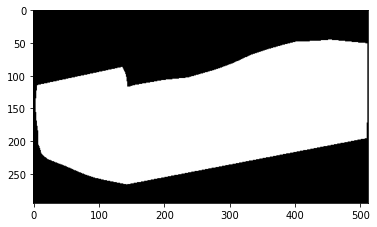

In [9]:
mask=cv2.imread(mask_img_paths[5])
mask[mask>0]=255
plt.imshow(mask)
plt.show()

In [10]:
def load_json(path):
  with open(path,'r') as f:
    dic=json.load(f)
  return dic

class my_dataset(Dataset):

  def __init__(self,path_dic):
    self.dic=load_json(path_dic)
    self.img_paths=list(self.dic.keys())
    self.mask_paths=list(self.dic.values())
    self.preprocess = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Resize((300,300)),           
                      #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                      ])


  def get(self,paths,idx):
    img_path=paths[idx]
    img=cv2.imread(img_path)
    tail=img_path.split('.')[-1]
    if tail=='jpg':
      img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif tail=='png':
      img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img=self.preprocess(img)
    #img=img.permute(2,1,0)
    
    return img


  def __getitem__(self,idx):
    img=self.get(self.img_paths,idx)
    mask=self.get(self.mask_paths,idx)
    return img,mask*255

  def __len__(self):
    return len(self.img_paths)

In [11]:
train_dataset=my_dataset(train_export_data_path)
val_dataset=my_dataset(val_export_data_path)
test_dataset=my_dataset(test_export_data_path)

In [12]:
train_dataloader = torch.utils.data.DataLoader(
   train_dataset,
   batch_size=BATCH_SIZE,
   num_workers=WORKER_N,
   shuffle=True,
   )

val_dataloader = torch.utils.data.DataLoader(
   val_dataset,
   batch_size=BATCH_SIZE,
   num_workers=WORKER_N,
   shuffle=True,
   )

test_dataloader = torch.utils.data.DataLoader(
   test_dataset,
   batch_size=BATCH_SIZE,
   num_workers=WORKER_N,
   shuffle=False,
   )

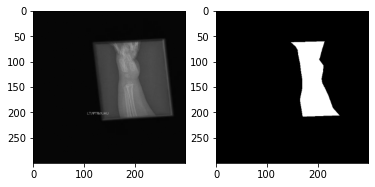

In [13]:
img,mask=test_dataset[0]
img=img.permute(1,2,0)
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask[0], cmap='gray')
plt.show()

In [14]:
from torch.nn.functional import sigmoid

def createDeepLabv3(classes_n=1):
    model = models.segmentation.deeplabv3_resnet101(pretrained=True,progress=True)
    model.classifier = DeepLabHead(2048, classes_n)
    return model
model=createDeepLabv3()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


In [53]:
from sklearn.metrics import jaccard_score

def pre_iou(p,thre=0.05):
  p[p<=0.05]=0
  p[p>0.05]=1
  return p.astype(int)

def iou(out, label):
    out = torch.reshape(out, [out.shape[0], -1]).numpy()
    label = torch.reshape(label, [label.shape[0], -1]).numpy()
    average_score=0
    for p, l in zip(out, label):
        
        p=pre_iou(p)
        l=pre_iou(l)
        score = jaccard_score(p, l, average='macro')
        average_score += score

    return average_score / len(out)



In [16]:
best_point=9999
model.to(DEVICE)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer=torch.optim.Adam(model.parameters(), lr=3e-4)
for epoch in range(EPOCH_N):
  print("Training...")
  train_loss=0
  val_loss=0
  iou_train=[]
  iou_val=[]
  for imgs,masks in tqdm(train_dataloader):
    model.train()
    optimizer.zero_grad()
    imgs=imgs.to(DEVICE)
    masks=masks.to(DEVICE)
    outs=model(imgs)
    outs=torch.sigmoid(outs['out'])
    loss=criterion(outs,masks)  	
    loss.backward()
    optimizer.step()
    train_loss+=loss.item()
    iou_train+=iou(outs,masks)
  for imgs,masks in tqdm(val_dataloader):
    model.eval()
    imgs=imgs.to(DEVICE)
    masks=masks.to(DEVICE)
    outs=model(imgs)
    outs=torch.sigmoid(outs['out'])
    loss=criterion(outs,masks)
    val_loss+=loss.item()
    iou_val+=iou(imgs,masks)
  if val_loss<best_point:
    best_point=val_loss
    torch.save(model.state_dict(), "./model.pth")
  print("------------------------->", train_loss,iou_train,val_loss,iou_val)

In [17]:
model.load_state_dict(torch.load("./model.pth"))

<All keys matched successfully>

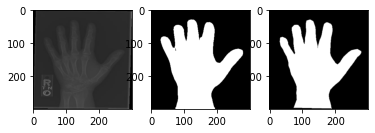

In [18]:
img,mask=test_dataset[14]
img_=img.permute(1,2,0)
img=img.reshape(1,img.shape[0],img.shape[1],img.shape[2])

with torch.no_grad():
    out = model.eval().cpu()(img)['out'][0]
    out=torch.sigmoid(out)

out[out>0.05]=1
out[out<=0.05]=0
plt.subplot(1,3,1)
plt.imshow(img_)
plt.subplot(1,3,2)
plt.imshow(out[0], cmap='gray')
plt.subplot(1,3,3)
plt.imshow(mask[0], cmap='gray')
plt.show()

In [59]:
for imgs,masks in tqdm(test_dataloader):  
    with torch.no_grad():
      outs = model.eval().cpu()(imgs)['out']
      outs=torch.sigmoid(outs)
      iou_ = iou(outs,masks)
      test_iou+=iou_
      i+=1
      

print(test_iou/i)



0.944913441472068
